# Lab 3 A: Neural Network for Customer Churn Prediction

**Dataset:** `churn.csv`  
**Goal:** Predict whether a bank customer will leave the bank (`Exited = 1`) using a neural network classifier.

You will implement the following pieces:

1. `prepare_data(df)` – preprocessing, encoding, scaling, train/validation split  
2. `ChurnDataset` – custom PyTorch Dataset  
3. `build_model(input_dim)` – neural network classifier  
4. `train_one_epoch(model, train_loader, criterion, optimizer)` – train loop for one epoch  
5. `evaluate(model, val_loader)` – compute validation accuracy

All these will be **autograded** with nbgrader.

**Important:**  
- Do not change function names or their parameters.  
- Do not change the return types.  
- Do not remove or rename variables used in the templates.

In [207]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from tqdm import tqdm

df = pd.read_csv("churn.csv")
df.sample()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
122,123,15690673,Cameron,656,France,Female,39,6,0.0,2,1,0,141069.88,0


In [208]:
df.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4624,4625,15710543,Okwuoma,629,France,Male,46,1,130666.20,1,1,1,161125.67,1
4419,4420,15677586,Romero,587,Germany,Female,32,3,125445.04,2,1,1,130514.78,0
9538,9539,15572767,Shelby,777,France,Male,29,2,0.00,2,1,0,124489.88,0
4586,4587,15664895,Onuchukwu,602,France,Female,25,0,0.00,2,1,1,101274.17,0
7170,7171,15621244,Gallo,678,France,Male,36,0,107379.68,1,1,1,84460.18,0


In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [210]:
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [211]:
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [212]:
### AUTOGRADED TASK
def prepare_data(df: pd.DataFrame):
    """
    Prepare the churn data for a neural network.

    Steps (you MUST follow these steps):
    1. Drop the columns: "RowNumber", "CustomerId", "Surname"
    2. Separate features (X) and target (y), where target is "Exited"
    3. Use ColumnTransformer with OneHotEncoder to encode:
       - categorical columns: ["Geography", "Gender"]
       - use OneHotEncoder(drop="first", sparse_output=False) 
         (if sparse_output doesn't exist in your sklearn, use sparse=False instead)
    4. Apply the transformer to X to get a numeric numpy array
    5. Apply StandardScaler to ALL resulting features
    6. Split into train and validation sets using:
         - test_size=0.2
         - random_state=42
         - stratify=y
    7. Return:
         X_train, X_val, y_train, y_val, preprocessor, scaler
    """

    # YOUR CODE HERE
    cpy = df.copy()
    
    # 1 
    cpy.drop(columns=["RowNumber", "CustomerId", "Surname"], inplace=True) 

    # 2 
    X, y = cpy.drop(columns=["Exited"]), cpy["Exited"]
     
    # 3
    cols = ['Geography', 'Gender']
    oh_enc = OneHotEncoder(drop="first", sparse_output=False) 

    ct = ColumnTransformer( [ ('onehot', oh_enc, cols) ], remainder='passthrough')

    # 4 
    X = ct.fit_transform(X)

    # 5
    std_scl = StandardScaler()
    X = std_scl.fit_transform(X)

    # 6 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 7 
    return X_train, X_val, y_train, y_val, ct, std_scl

In [213]:
X_train, X_val, y_train, y_val, preprocessor, scaler = prepare_data(df)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8000, 11), (2000, 11), (8000,), (2000,))

In [214]:
### AUTOGRADED TASK
class ChurnDataset(Dataset):
    """
    A PyTorch Dataset for the churn data.

    - __init__(self, X, y):
        * X: numpy array of features
        * y: array-like of labels (0 or 1)
        * store them as tensors:
             - X as float32
             - y as float32 with shape (N, 1)
    - __len__(self): returns number of samples
    - __getitem__(self, idx): returns (X[idx], y[idx])
    """

    # YOUR CODE HERE
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(np.array(y)).float().reshape(-1)  #.reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [215]:
train_ds = ChurnDataset(X_train, y_train)
val_ds = ChurnDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

len(train_ds), len(val_ds)

(8000, 2000)

In [216]:
### AUTOGRADED TASK
def build_model(input_dim: int) -> nn.Module:
    """
    Build and return a PyTorch neural network for binary classification.

    Requirements:
    - Use nn.Sequential
    - Architecture suggestion (you may use exactly this):
        Linear(input_dim, 32) -> ReLU
        Linear(32, 16) -> ReLU
        Linear(16, 1) -> Sigmoid
    - The final layer MUST have 1 neuron with Sigmoid activation (output in [0,1]).
    """

    # YOUR CODE HERE
    class ExitedNet(nn.Module):
        def __init__(self, in_features: int):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 32),
                nn.ReLU(),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16, 1),
                nn.Sigmoid()
            )

        def forward(self, x):
            # Output shape: (batch_size,)
            return self.net(x).squeeze(1)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    return ExitedNet(in_features=X_train.shape[1]).to(device)
    

In [217]:
input_dim = X_train.shape[1]
model = build_model(input_dim)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

Using device: cpu


ExitedNet(
  (net): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [218]:
### AUTOGRADED TASK
def train_one_epoch(model: nn.Module,
                    train_loader: DataLoader,
                    criterion,
                    optimizer) -> float:
    """
    Train the model for ONE epoch on the training data.

    Requirements:
    - Set model to train mode: model.train()
    - Loop over batches from train_loader
      * Compute predictions
      * Compute loss
      * Zero the gradients
      * Backpropagate
      * Step the optimizer
      * Accumulate the loss (sum)
    - Return the average training loss as a float 
      (total loss divided by number of batches)
    """
    # YOUR CODE HERE
    model.train()
    loss_sum = 0.0
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    progress_bar = tqdm(train_loader, leave=False)

    for X_batch, y_batch in progress_bar:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return loss_sum / len(progress_bar)

In [219]:
### AUTOGRADED TASK
def evaluate(model: nn.Module, val_loader: DataLoader) -> float:
    """
    Evaluate the model on the validation data.

    Requirements:
    - Set the model to eval mode: model.eval()
    - Disable gradients using torch.no_grad()
    - Loop over batches from val_loader:
        * Compute predictions
        * Convert predictions to labels using threshold 0.5
        * Collect all true labels and predicted labels
    - Return the accuracy on the full validation set as a float in [0, 1].
    """

    # YOUR CODE HERE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    all_probs = []
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)

            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= 0.5).astype(int)

            all_probs.append(probs)
            all_preds.append(preds)
            all_targets.append(y_batch.numpy())

    all_probs = np.concatenate(all_probs).reshape(-1)
    all_preds = np.concatenate(all_preds).reshape(-1)
    all_targets = np.concatenate(all_targets).reshape(-1)

    acc = accuracy_score(all_targets, all_preds)
    return acc #, all_targets, all_preds

In [220]:
epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f}")

Epoch 1/10 | Train loss: 0.5528 | Val acc: 0.2035


Epoch 2/10 | Train loss: 0.4376 | Val acc: 0.2035


Epoch 3/10 | Train loss: 0.4135 | Val acc: 0.2035


Epoch 4/10 | Train loss: 0.3951 | Val acc: 0.2035


Epoch 5/10 | Train loss: 0.3711 | Val acc: 0.2035


Epoch 6/10 | Train loss: 0.3545 | Val acc: 0.2035


Epoch 7/10 | Train loss: 0.3464 | Val acc: 0.2035


Epoch 8/10 | Train loss: 0.3417 | Val acc: 0.2035


Epoch 9/10 | Train loss: 0.3388 | Val acc: 0.2035


Epoch 10/10 | Train loss: 0.3372 | Val acc: 0.2035


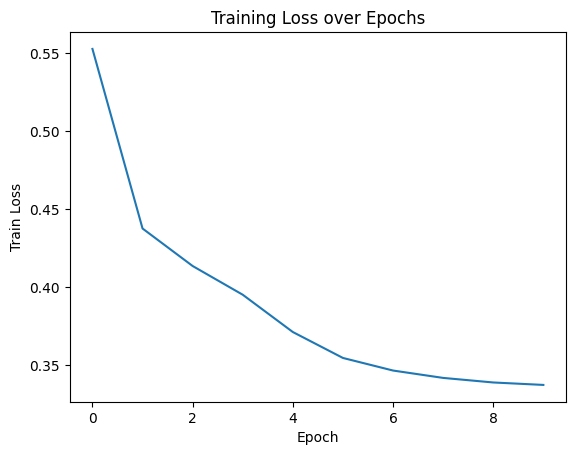

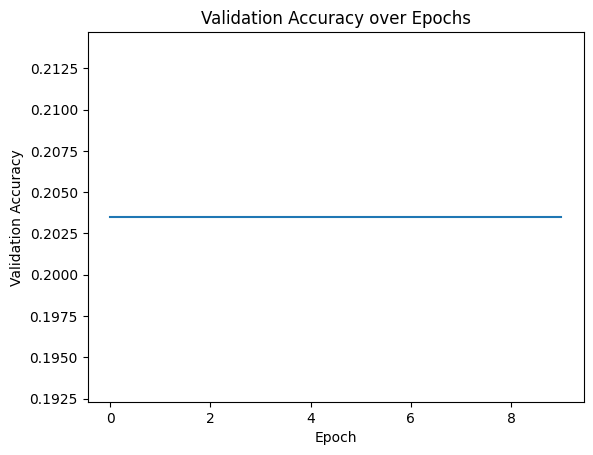

In [221]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss over Epochs")
plt.show()

plt.plot(val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.show()

In [222]:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

## Answer

1. What validation accuracy did you reach?
> Достигната е валидациска точност од 20.35%
2. Does the model appear to overfit or underfit?   
#### TODO !!!!!!!!
> Моделот изгледа дека е overfit бидејќи тренирачка загуба се намалува за секоја епоха, но валидациска прецизност не се менува.
3. Name one way to potentially improve performance (architecture or preprocessing).
> Еден начин како да се подобрат перформанците е да извршиме undersampling на класа 0, множеството е небалансирано 

## Run the tests to verify your solution

In [223]:
import hashlib
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

def hash_data_frame(df: pd.DataFrame) -> str:
    """
    Compute a stable hash for a DataFrame by:
    - sorting columns
    - sorting rows by all columns
    - hashing the underlying values
    """
    df_sorted = df.sort_index(axis=1).sort_values(by=list(df.columns))
    return hashlib.sha256(pd.util.hash_pandas_object(df_sorted, index=True).values).hexdigest()

def hash_series(series: pd.Series) -> str:
    """
    Compute a stable hash for a Series by:
    - converting values to string
    - joining with commas
    - hashing the resulting string
    """
    series_str = ",".join(map(str, series.values))
    return hashlib.sha256(series_str.encode()).hexdigest()

def check_signature(expected: str, actual: str):
    try:
        assert actual == expected
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

def test_prepare_data(func, sig_X_train, sig_X_val, sig_y_train, sig_y_val):
    """
    Wrapper for testing the student's `prepare_data(df)` function using hashes.
    """
    df = pd.read_csv("churn.csv")
    X_train, X_val, y_train, y_val, preprocessor, scaler = func(df)

    # Convert to DataFrame / Series for hashing
    X_train_df = pd.DataFrame(X_train)
    X_val_df = pd.DataFrame(X_val)
    y_train_s = pd.Series(y_train).reset_index(drop=True)
    y_val_s = pd.Series(y_val).reset_index(drop=True)

    # Basic sanity
    assert X_train_df.shape[0] > 0
    assert X_val_df.shape[0] > 0
    assert X_train_df.shape[1] == X_val_df.shape[1]

    # Hashes
    h_Xtr = hash_data_frame(X_train_df)
    h_Xv  = hash_data_frame(X_val_df)
    h_ytr = hash_series(y_train_s)
    h_yv  = hash_series(y_val_s)

    try:
        assert h_Xtr == sig_X_train
        assert h_Xv  == sig_X_val
        assert h_ytr == sig_y_train
        assert h_yv  == sig_y_val
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed (signatures do not match).")
        # Uncomment while generating signatures:
        # print("DEBUG:", h_Xtr, h_Xv, h_ytr, h_yv)
        raise

In [224]:
### TEST
SIG_X_TRAIN = "5c50238ec85cb41c11b0eabc4be851c56a41aa367bc3945dcfc07e83a5e8e079"
SIG_X_VAL   = "4ef850e8dea3a9f462535f178165dc02b06a1f5e31ac9d364d779b291407d33a"
SIG_Y_TRAIN = "9b8c6fff66645ef6ca27fb516a51c4c9d2645710f2809c05887d98fa938e93e4"
SIG_Y_VAL   = "516080ad1fc8e2349df09a1de08ffb3fc50d7ff7a36c5f4f82af08b8ef55f783"

test_prepare_data(
    prepare_data,
    SIG_X_TRAIN,
    SIG_X_VAL,
    SIG_Y_TRAIN,
    SIG_Y_VAL
)


✔ Test passed!


In [234]:
### TEST 
train_ds = ChurnDataset(X_train, y_train)

# basic length
assert len(train_ds) == X_train.shape[0]

# sample item
x0, y0 = train_ds[0]
assert isinstance(x0, torch.Tensor)
assert isinstance(y0, torch.Tensor)
assert x0.shape[0] == X_train.shape[1]
assert y0.shape == (1,) # TODO
assert x0.dtype == torch.float32
assert y0.dtype == torch.float32

print("✔ Test passed!")


AssertionError: 

In [228]:
### TEST 
input_dim = X_train.shape[1]
model_test = build_model(input_dim)

assert isinstance(model_test, torch.nn.Module)

dummy = torch.randn(4, input_dim)
out = model_test(dummy)

print(out.shape)

# output shape and range
assert out.shape == (4, 1) # TODO
assert torch.all(out >= 0.0)
assert torch.all(out <= 1.0)

print("✔ Test passed!")


Using device: cpu
torch.Size([4])


AssertionError: 

In [229]:
### TEST 
train_loader_test = DataLoader(ChurnDataset(X_train, y_train), batch_size=64, shuffle=True)

model_te = build_model(X_train.shape[1])
criterion_te = torch.nn.BCELoss()
optimizer_te = torch.optim.Adam(model_te.parameters(), lr=0.001)

loss1 = train_one_epoch(model_te, train_loader_test, criterion_te, optimizer_te)

assert isinstance(loss1, float)
assert 0.0 < loss1 < 10.0   # loose bounds

print("✔ Test passed!")


Using device: cpu


✔ Test passed!


In [230]:
### TEST 
val_loader_test = DataLoader(ChurnDataset(X_val, y_val), batch_size=256, shuffle=False)

acc_val = evaluate(model_te, val_loader_test)

assert isinstance(acc_val, float)
assert 0.0 <= acc_val <= 1.0

print("✔ Test passed!")


✔ Test passed!
